## Heteroscedastic uncertainty

### Example of learning the aleatoric heteroscedastic uncertainty by learning a simple linear regression

In [1]:
#!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


First we create some samples from 0 to 40 and add some noise in two batches, from 0 to 20 with std equals to 4, and from 20 to 40 with std 1. This is what we eant to predict as the uncertainty of the predictions based on the noise of the input data.

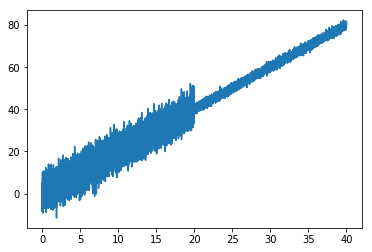

In [2]:
x = np.linspace(0, 20, 10000)#, dtype="int32")  # 100000 values between 0 and 100
delta = np.random.normal(0, 4, x.size)
y = 2*x + delta
x2 = np.linspace(20, 40, 10000)
delta2 = np.random.normal(0, 1, x2.size)
y2 = 2*x2 + delta2
x = np.append(x, x2)
y = np.append(y, y2)
plt.plot(x,y)
plt.show()

These are the function used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output.

In [3]:
def aleatoric_loss(y_true, y_pred):
    sigma = K.log(K.exp(y_pred[:, 1]) + 1)
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (K.square(sigma) + epsilon)) + K.log(K.square(sigma) + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    return K.mean(K.square(y_pred_prima - y_true[:, 0]), axis=-1)

def aleatoric_uncertainty(y_true, y_pred):
    sigma = y_pred[:, 1]
    return K.max(K.log(K.square(sigma)), axis=-1)

First we try a model without calculating the sigma and plot the results to see that the model is predicting the right values.

Epoch 1/40
20000/20000 [==============================] - 0s - loss: 1249.2658 - mean_squared_error: 1249.2658     
Epoch 2/40
20000/20000 [==============================] - 0s - loss: 1009.8007 - mean_squared_error: 1009.8007     
Epoch 3/40
20000/20000 [==============================] - 0s - loss: 806.6624 - mean_squared_error: 806.6624     
Epoch 4/40
20000/20000 [==============================] - 0s - loss: 636.2087 - mean_squared_error: 636.2087     
Epoch 5/40
20000/20000 [==============================] - 0s - loss: 494.8519 - mean_squared_error: 494.8519     
Epoch 6/40
20000/20000 [==============================] - 0s - loss: 379.0460 - mean_squared_error: 379.0460     
Epoch 7/40
20000/20000 [==============================] - 0s - loss: 285.6841 - mean_squared_error: 285.6841     
Epoch 8/40
20000/20000 [==============================] - 0s - loss: 211.5835 - mean_squared_error: 211.5835     
Epoch 9/40
20000/20000 [==============================] - 0s - loss: 153.8579 - mean

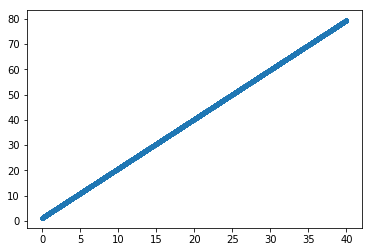

In [4]:
raw_inputs = Input(shape=(1,))
raw_preds = Dense(1, activation='linear', name="preds")(raw_inputs)

rawmodel = Model(inputs=raw_inputs,outputs=raw_preds)
rawmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
rawmodel.fit(x, y, batch_size=128, epochs=40, shuffle=True)
x_raw_pred = np.array([1,2,3,4,5,6,7,8,9,10,15,20])
raw_result = rawmodel.predict(x)
plt.plot(x, raw_result[:,0],'.')
plt.show()

Then we try a model where the sigma is the result of a combination of 3 layers.

In [5]:
inputs = Input(shape=(1,))
sigma = Dense(15, activation='relu', name="sigma", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(inputs)
sigma2 = Dense(10, activation='relu', name="sigma2", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(sigma)
sigma3 = Dense(1, activation='linear', name="sigma3", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(sigma2)
preds = Dense(1, activation='linear', name="preds")(inputs)
aleatoric_output = concatenate([preds, sigma3])
sgd = SGD(lr=0.1)
adam = Adam(lr=0.0003)
rms = RMSprop(lr=0.001)
nadam = Nadam(lr=0.001)
model = Model(inputs=inputs,outputs=aleatoric_output)
model.compile(optimizer=adam, loss=aleatoric_loss, metrics=[aleatoric_rms, aleatoric_uncertainty])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
sigma (Dense)                    (None, 15)            30          input_2[0][0]                    
____________________________________________________________________________________________________
sigma2 (Dense)                   (None, 10)            160         sigma[0][0]                      
____________________________________________________________________________________________________
preds (Dense)                    (None, 1)             2           input_2[0][0]                    
___________________________________________________________________________________________

In [6]:
model.fit(x, np.expand_dims(y, axis=1).repeat(2, axis=1), batch_size=64, epochs=200, shuffle=True)

Epoch 1/200
20000/20000 [==============================] - 0s - loss: 450.0504 - aleatoric_rms: 370.6588 - aleatoric_uncertainty: -2.0552     
Epoch 2/200
20000/20000 [==============================] - 0s - loss: 62.5468 - aleatoric_rms: 340.8138 - aleatoric_uncertainty: 2.4815     
Epoch 3/200
20000/20000 [==============================] - 0s - loss: 26.2732 - aleatoric_rms: 331.6773 - aleatoric_uncertainty: 3.5306     
Epoch 4/200
20000/20000 [==============================] - 0s - loss: 16.9356 - aleatoric_rms: 325.7957 - aleatoric_uncertainty: 4.1004     
Epoch 5/200
20000/20000 [==============================] - 0s - loss: 12.8310 - aleatoric_rms: 321.1466 - aleatoric_uncertainty: 4.5017     
Epoch 6/200
20000/20000 [==============================] - 0s - loss: 10.5964 - aleatoric_rms: 317.1218 - aleatoric_uncertainty: 4.8136     
Epoch 7/200
20000/20000 [==============================] - 0s - loss: 9.2323 - aleatoric_rms: 313.4758 - aleatoric_uncertainty: 5.0729     
Epoch 8/200


20000/20000 [==============================] - 0s - loss: 2.4740 - aleatoric_rms: 8.6359 - aleatoric_uncertainty: 3.1627     
Epoch 60/200
20000/20000 [==============================] - 0s - loss: 2.4713 - aleatoric_rms: 8.6320 - aleatoric_uncertainty: 3.1578     
Epoch 61/200
20000/20000 [==============================] - 0s - loss: 2.4697 - aleatoric_rms: 8.6282 - aleatoric_uncertainty: 3.1396     
Epoch 62/200
20000/20000 [==============================] - 0s - loss: 2.4665 - aleatoric_rms: 8.6247 - aleatoric_uncertainty: 3.1093     
Epoch 63/200
20000/20000 [==============================] - 0s - loss: 2.4644 - aleatoric_rms: 8.6210 - aleatoric_uncertainty: 3.1042     
Epoch 64/200
20000/20000 [==============================] - 0s - loss: 2.4619 - aleatoric_rms: 8.6166 - aleatoric_uncertainty: 3.0814     
Epoch 65/200
20000/20000 [==============================] - 0s - loss: 2.4589 - aleatoric_rms: 8.6125 - aleatoric_uncertainty: 3.0675     
Epoch 66/200
20000/20000 [==============

20000/20000 [==============================] - 0s - loss: 2.4106 - aleatoric_rms: 8.5571 - aleatoric_uncertainty: 2.8347     
Epoch 118/200
20000/20000 [==============================] - 0s - loss: 2.4102 - aleatoric_rms: 8.5569 - aleatoric_uncertainty: 2.8241     
Epoch 119/200
20000/20000 [==============================] - 0s - loss: 2.4106 - aleatoric_rms: 8.5568 - aleatoric_uncertainty: 2.8209     
Epoch 120/200
20000/20000 [==============================] - 0s - loss: 2.4094 - aleatoric_rms: 8.5568 - aleatoric_uncertainty: 2.8264     
Epoch 121/200
20000/20000 [==============================] - 0s - loss: 2.4103 - aleatoric_rms: 8.5565 - aleatoric_uncertainty: 2.8298     
Epoch 122/200
20000/20000 [==============================] - 0s - loss: 2.4105 - aleatoric_rms: 8.5560 - aleatoric_uncertainty: 2.8260     
Epoch 123/200
20000/20000 [==============================] - 0s - loss: 2.4095 - aleatoric_rms: 8.5559 - aleatoric_uncertainty: 2.8307     
Epoch 124/200
20000/20000 [=======

20000/20000 [==============================] - 0s - loss: 2.4000 - aleatoric_rms: 8.5533 - aleatoric_uncertainty: 2.8273     
Epoch 176/200
20000/20000 [==============================] - 0s - loss: 2.4023 - aleatoric_rms: 8.5529 - aleatoric_uncertainty: 2.8116     
Epoch 177/200
20000/20000 [==============================] - 0s - loss: 2.4020 - aleatoric_rms: 8.5533 - aleatoric_uncertainty: 2.8078     
Epoch 178/200
20000/20000 [==============================] - 0s - loss: 2.4014 - aleatoric_rms: 8.5526 - aleatoric_uncertainty: 2.8257     
Epoch 179/200
20000/20000 [==============================] - ETA: 0s - loss: 2.4014 - aleatoric_rms: 8.5417 - aleatoric_uncertainty: 2.807 - 0s - loss: 2.4003 - aleatoric_rms: 8.5526 - aleatoric_uncertainty: 2.8089     
Epoch 180/200
20000/20000 [==============================] - 0s - loss: 2.4009 - aleatoric_rms: 8.5521 - aleatoric_uncertainty: 2.8278     
Epoch 181/200
20000/20000 [==============================] - 0s - loss: 2.3997 - aleatoric_rms

Here we can see that predictions are still right and the sigmas obtained describe perfectly the variance of the noise introduced in the input data

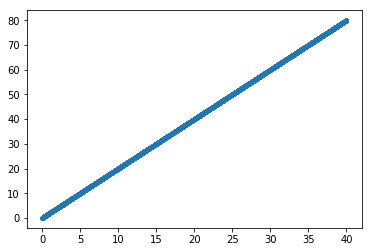

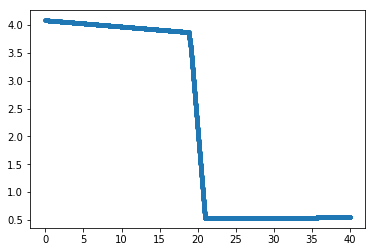

In [7]:
result = model.predict(x)
plt.plot(x, result[:,0],'.')
plt.show()
plt.plot(x, result[:,1],'.')
plt.show()
#result